<a href="https://colab.research.google.com/github/abhigyan2003/GAN/blob/main/Generative_adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.PPTTCG_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.PPTTCG_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 118s 185ms/step - d_loss: 0.5138 - g_loss: 1.0231
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 142ms/step - d_loss: 0.2904 - g_loss: 4.5655
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.5175 - g_loss: 4.3654
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.6921 - g_loss: 0.6909
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.6967 - g_loss: 0.6433
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - d_loss: 0.6937 - g_loss: 0.6497
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - d_loss: 0.6971 - g_loss: 0.6519
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - d_loss: 0.6916 - g_loss: 0.6617
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - d_loss: 0.6934 - g_loss: 0.6572
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.6901 - g_loss: 0.6542
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - d_loss: 0.5968 - g_loss: 1.2057
Epoch 12/20
469/469 ━━━━━━━━━

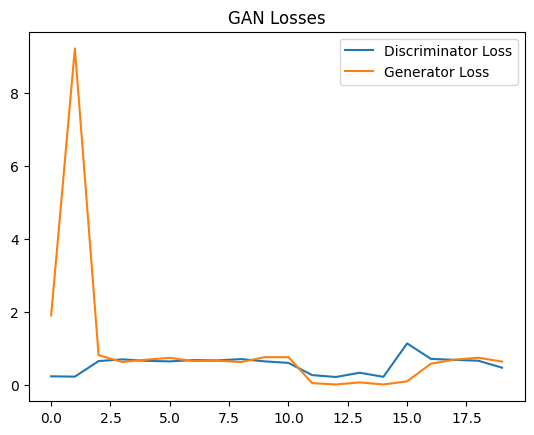

In [1]:
# Install required libraries
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os

# Enable memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load and preprocess dataset
def scale_images(data):
    image = tf.cast(data['image'], tf.float32) / 255.0
    return tf.reshape(image, (28, 28, 1))

ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images).cache().shuffle(60000).batch(128).prefetch(64)

# Generator model
def build_generator(latent_dim=128):
    model = Sequential([
        Dense(7*7*128, input_dim=latent_dim),
        LeakyReLU(0.2),
        Reshape((7, 7, 128)),

        UpSampling2D(),
        Conv2D(128, kernel_size=5, padding='same'),
        LeakyReLU(0.2),

        UpSampling2D(),
        Conv2D(128, kernel_size=5, padding='same'),
        LeakyReLU(0.2),

        Conv2D(128, kernel_size=4, padding='same'),
        LeakyReLU(0.2),

        Conv2D(128, kernel_size=4, padding='same'),
        LeakyReLU(0.2),

        Conv2D(1, kernel_size=4, padding='same', activation='sigmoid')
    ])
    return model

# Discriminator model
def build_discriminator():
    model = Sequential([
        Conv2D(32, kernel_size=5, input_shape=(28, 28, 1)),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(64, kernel_size=5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(128, kernel_size=5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(256, kernel_size=5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate models
latent_dim = 128
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# Optimizers and losses
g_opt = Adam(learning_rate=1e-4)
d_opt = Adam(learning_rate=1e-5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# Custom GAN class
class FashionGAN(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss):
        super().compile()
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal((batch_size, latent_dim))

        with tf.GradientTape() as d_tape:
            fake_images = self.generator(random_latent_vectors, training=False)
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_combined = tf.concat([yhat_real, yhat_fake], axis=0)
            y_combined = tf.concat([
                tf.zeros_like(yhat_real) + 0.1 * tf.random.uniform(tf.shape(yhat_real)),
                tf.ones_like(yhat_fake) - 0.1 * tf.random.uniform(tf.shape(yhat_fake))
            ], axis=0)
            total_d_loss = self.d_loss(y_combined, yhat_combined)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            predictions = self.discriminator(generated_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predictions), predictions)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

# Callback to monitor generated images
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()
        if not os.path.exists('images'):
            os.makedirs('images')
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(f'images/generated_img_{epoch}_{i}.png')

# Training
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)
history = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor(num_img=4)])

# Plot loss curves
plt.plot(history.history['d_loss'], label='Discriminator Loss')
plt.plot(history.history['g_loss'], label='Generator Loss')
plt.legend()
plt.title('GAN Losses')
plt.show()

# Save models
generator.save('generator.h5')
discriminator.save('discriminator.h5')
